# Shapelet classification

In [1]:
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform
from utils import  amplitude_scaling, load_dataset, save_distance_matrix, decode_y, top_flop_f1
import numpy as np
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    make_scorer
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

## PAA-128

In [2]:
X_train, y_train, X_test, y_test, enc_dict = load_dataset('../dataset_ts/ts_data_paa128.npz')

In [3]:
# amplitude scaling
X_train_scaled = np.squeeze(X_train)
X_test_scaled = np.squeeze(X_test)

# li porto al formato standard di tslearn (diverso da sktime)
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled= np.expand_dims(X_test_scaled, axis=2)

In [4]:
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
import tensorflow as tf

In [5]:
X_val = X_train_scaled[6000:]
X_train = X_train_scaled[:6000]

In [6]:
shp_clf = LearningShapelets(n_shapelets_per_size={20:1000},
                            optimizer=tf.optimizers.Adam(learning_rate=0.0005),
                            batch_size=256,
                            weight_regularizer=0,
                            max_iter=800,
                            random_state=8,
                            verbose=1,
                            scale=False)


c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [7]:
shp_clf.fit(X_train_scaled, y_train)

Epoch 1/800
30/30 [==============================] - 5s 139ms/step - loss: 1173311.8750 - categorical_accuracy: 0.0743 - categorical_crossentropy: 1173311.8750
Epoch 2/800
30/30 [==============================] - 4s 147ms/step - loss: 347803.0000 - categorical_accuracy: 0.1124 - categorical_crossentropy: 347803.0000
Epoch 3/800
30/30 [==============================] - 4s 146ms/step - loss: 245683.0625 - categorical_accuracy: 0.1241 - categorical_crossentropy: 245683.0625
Epoch 4/800
30/30 [==============================] - 4s 139ms/step - loss: 246525.6250 - categorical_accuracy: 0.1208 - categorical_crossentropy: 246525.6250
Epoch 5/800
30/30 [==============================] - 4s 138ms/step - loss: 229687.0156 - categorical_accuracy: 0.1219 - categorical_crossentropy: 229687.0156
Epoch 6/800
30/30 [==============================] - 4s 135ms/step - loss: 227298.8125 - categorical_accuracy: 0.1179 - categorical_crossentropy: 227298.8125
Epoch 7/800
30/30 [==============================]

LearningShapelets(max_iter=800, n_shapelets_per_size={20: 1000},
                  optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x0000020C06013850>,
                  random_state=8, verbose=1, weight_regularizer=0)

In [8]:
spts = shp_clf.shapelets_as_time_series_
spts.shape

(1000, 20, 1)

In [9]:
X_train_dist = shp_clf.transform(X_train)
X_val_dist = shp_clf.transform(X_val)

6/6 [==============================] - 0s 71ms/step


In [3]:
X_train_dist_tot = np.load('../dataset_ts/ts_data_shp.npz')['X_train']
X_test_dist_tot = np.load('../dataset_ts/ts_data_shp.npz')['X_test']

scaler = MinMaxScaler()
X_train_dist_tot = scaler.fit_transform(X_train_dist_tot)
X_test_dist = scaler.transform(X_test_dist_tot)


X_train_dist = X_train_dist_tot[:6000]
X_val_dist = X_train_dist_tot[6000:]



Decision Tree:

In [11]:
parameters = {'criterion': ['entropy'],
              'min_samples_split': [32,64,128,200,300,400,500,600,700],
              'min_samples_leaf': [10,14,18,24,30,40,50,60,75,100],
              }
dtc = DecisionTreeClassifier(random_state=8)
clf = GridSearchCV(
    dtc, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    verbose=2
    )
clf.fit(np.concatenate((X_train_dist, X_val_dist), axis=0), y_train)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
DecisionTreeClassifier(criterion='entropy', min_samples_leaf=40,
                       min_samples_split=128, random_state=8)
{'criterion': 'entropy', 'min_samples_leaf': 40, 'min_samples_split': 128}
0.2512


                   precision    recall  f1-score   support

              emo       0.12      0.08      0.10       375
             folk       0.08      0.02      0.04       375
             goth       0.12      0.06      0.08       375
            happy       0.36      0.48      0.41       375
      heavy-metal       0.21      0.33      0.25       375
       honky-tonk       0.17      0.26      0.21       375
           j-idol       0.23      0.22      0.22       375
             kids       0.22      0.26      0.24       375
   minimal-techno       0.45      0.39      0.42       375
              mpb       0.10      0.07      0.08       375
          new-age       0.43      0.44      0.44       375
            opera       0.24      0.26      0.25       375
            piano       0.53      0.45      0.49       375
progressive-house       0.24      0.24      0.24       375
            salsa       0.19      0.27      0.22       375
        sertanejo       0.18      0.31      0.23       

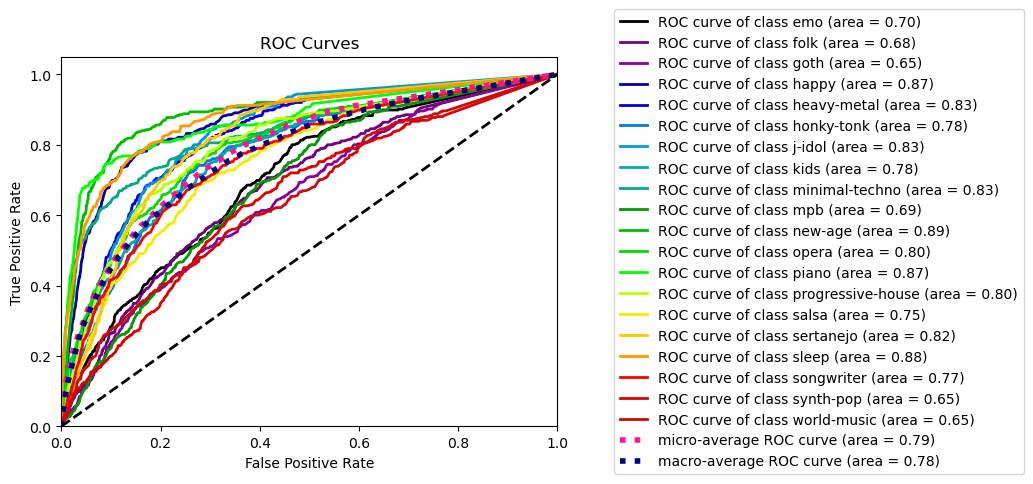

TOP 5 F1-SCORE:
piano: 0.48554913294797686
sleep: 0.45178335535006603
new-age: 0.43799472295514513
minimal-techno: 0.4186704384724187
happy: 0.41008018327605955


FLOP 5 F1-SCORE:
folk: 0.037037037037037035
synth-pop: 0.06336633663366337
goth: 0.07692307692307693
mpb: 0.08240887480190175
emo: 0.0967238689547582


In [5]:
# decision tree selected model
model = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=40,
                       min_samples_split=128, random_state=8)
y_pred = decode_y(cross_val_predict(model, X_train_dist_tot, y_train, cv=10), enc_dict)
y_pred_proba = cross_val_predict(model, X_train_dist_tot, y_train, cv=10, method='predict_proba')

print(classification_report(decode_y(y_train, enc_dict), y_pred))
plot_roc(decode_y(y_train, enc_dict), y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(decode_y(y_train, enc_dict), y_pred)

In [12]:
model = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=40,
                       min_samples_split=128, random_state=8)
model.fit(X_train_dist_tot, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=40,
                       min_samples_split=128, random_state=8)

In [22]:
# potrei estrarre le shapelet più importanti
importances = model.feature_importances_
indices = list(reversed(np.argsort(importances)))
indices[:4]


[372, 746, 934, 602]

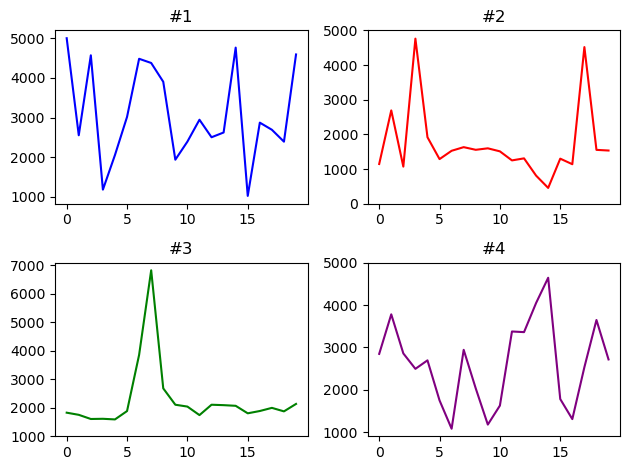

In [54]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(spts[372], c='blue')
axs[0, 0].set_title('#1')
axs[0, 1].plot(spts[746], c='red')
axs[0, 1].set_title('#2')
axs[0, 1].set_yticks(np.arange(0,6000, 1000))
axs[1, 0].plot(spts[934], c='green')
axs[1, 0].set_title('#3')
axs[1, 0].set_yticks(np.arange(1000,8000, 1000))
axs[1, 1].plot(spts[602], c='purple')
axs[1, 1].set_title('#4')
axs[1, 1].set_yticks(np.arange(1000,6000, 1000))
fig.tight_layout()

plt.show()

In [51]:
top_shapelets = np.squeeze(spts[indices[:10]])
np.savez('top10_shapelets', shp=top_shapelets)

KNN:

In [8]:

# knn
parameters = {'n_neighbors': [1,5,10,15,20,30,40,50,60,80,100,125,150,200],
              'weights': ['distance', 'uniform'],
              'metric': ['euclidean', 'cosine', 'manhattan'],
              'n_jobs': [-1]
              }
knn = KNeighborsClassifier()
clf = GridSearchCV(
    knn, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    )
clf.fit(np.concatenate((X_train_dist, X_val_dist), axis=0), y_train)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=30,
                     weights='distance')
{'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 30, 'weights': 'distance'}
0.25959999999999994


                   precision    recall  f1-score   support

              emo       0.20      0.07      0.11       375
             folk       0.12      0.09      0.10       375
             goth       0.12      0.07      0.09       375
            happy       0.37      0.48      0.42       375
      heavy-metal       0.21      0.46      0.29       375
       honky-tonk       0.20      0.32      0.24       375
           j-idol       0.22      0.41      0.28       375
             kids       0.29      0.15      0.20       375
   minimal-techno       0.56      0.23      0.33       375
              mpb       0.11      0.05      0.07       375
          new-age       0.34      0.46      0.39       375
            opera       0.20      0.30      0.24       375
            piano       0.53      0.45      0.49       375
progressive-house       0.36      0.29      0.32       375
            salsa       0.16      0.21      0.18       375
        sertanejo       0.23      0.40      0.30       

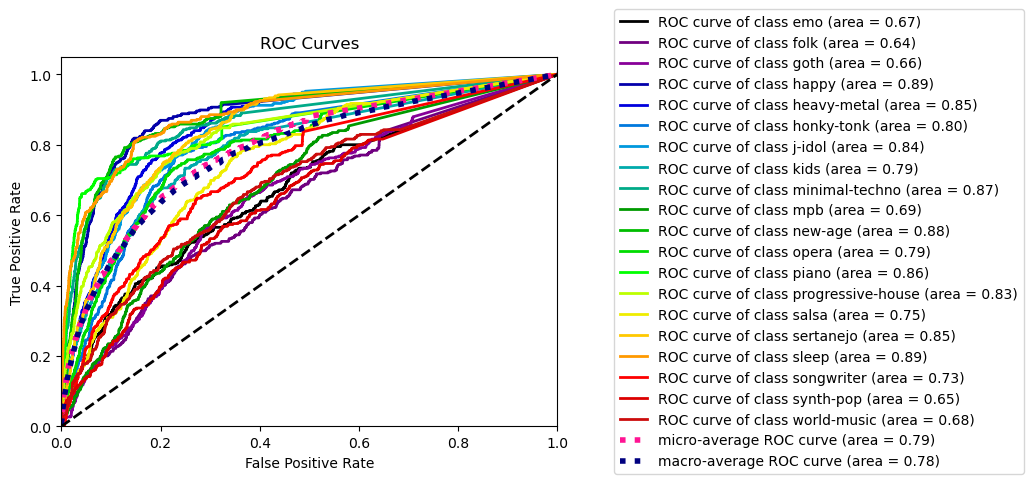

TOP 5 F1-SCORE:
piano: 0.4885057471264368
sleep: 0.4783950617283951
happy: 0.4184971098265896
new-age: 0.391353811149033
minimal-techno: 0.327683615819209


FLOP 5 F1-SCORE:
mpb: 0.0711743772241993
synth-pop: 0.07775377969762419
goth: 0.09256198347107437
folk: 0.10110584518167456
emo: 0.10916179337231968


In [13]:
# KNN selected model 
model = KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=30,
                     weights='distance')
y_pred = decode_y(cross_val_predict(model, X_train_dist_tot, y_train, cv=10), enc_dict)
y_pred_proba = cross_val_predict(model, X_train_dist_tot, y_train, cv=10, method='predict_proba')

print(classification_report(decode_y(y_train, enc_dict), y_pred))
plot_roc(decode_y(y_train, enc_dict), y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(decode_y(y_train, enc_dict), y_pred)

### Test:

In [12]:
#X_train_dist_tot = shp_clf.transform(X_train_scaled)
#X_test_dist = shp_clf.transform(X_test_scaled)

# salvo i dati di training e test
#np.savez('../dataset_ts/ts_data_shp', X_train=X_train_dist_tot, X_test=X_test_dist, y_train=y_train, y_test=y_test, enc_dict=enc_dict)

Decision Tree:

In [15]:
dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=40,
                       min_samples_split=128, random_state=8)
dt.fit(X_train_dist_tot, y_train)
y_pred = dt.predict(X_test_dist)
print(classification_report(decode_y(y_test, enc_dict), decode_y(y_pred,enc_dict)))

                   precision    recall  f1-score   support

              emo       0.25      0.06      0.09       125
             folk       0.11      0.04      0.06       125
             goth       0.13      0.09      0.11       125
            happy       0.32      0.42      0.36       125
      heavy-metal       0.21      0.30      0.25       125
       honky-tonk       0.25      0.26      0.25       125
           j-idol       0.19      0.18      0.19       125
             kids       0.26      0.22      0.24       125
   minimal-techno       0.37      0.39      0.38       125
              mpb       0.09      0.02      0.03       125
          new-age       0.45      0.47      0.46       125
            opera       0.23      0.28      0.25       125
            piano       0.52      0.42      0.46       125
progressive-house       0.19      0.30      0.23       125
            salsa       0.16      0.18      0.17       125
        sertanejo       0.17      0.42      0.24       

KNN:

In [17]:
knn = KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=30,
                     weights='distance')
knn.fit(X_train_dist_tot, y_train)
y_pred = knn.predict(X_test_dist)
print(classification_report(decode_y(y_test, enc_dict), decode_y(y_pred,enc_dict)))

                   precision    recall  f1-score   support

              emo       0.28      0.15      0.20       125
             folk       0.09      0.07      0.08       125
             goth       0.04      0.02      0.03       125
            happy       0.30      0.48      0.37       125
      heavy-metal       0.19      0.38      0.25       125
       honky-tonk       0.24      0.38      0.29       125
           j-idol       0.21      0.36      0.27       125
             kids       0.29      0.18      0.22       125
   minimal-techno       0.64      0.30      0.40       125
              mpb       0.18      0.08      0.11       125
          new-age       0.38      0.50      0.43       125
            opera       0.24      0.34      0.28       125
            piano       0.49      0.45      0.47       125
progressive-house       0.38      0.28      0.32       125
            salsa       0.16      0.22      0.18       125
        sertanejo       0.26      0.43      0.32       

## PCA

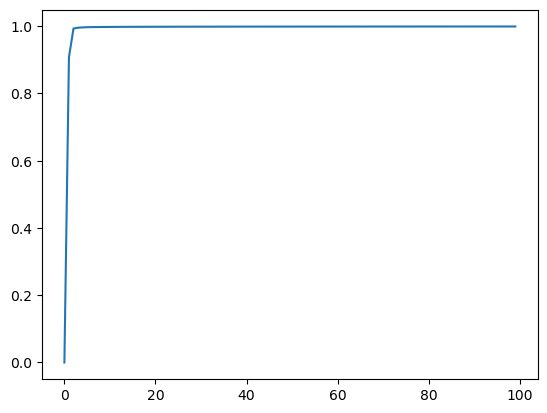

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
variance_ratio = PCA(n_components=100).fit(X_train_dist_tot).explained_variance_ratio_
cumulative = [np.sum(variance_ratio[:i]) for i in range(variance_ratio.shape[0])]
plt.plot(cumulative
         )

In [5]:
pca = PCA(n_components=10)
pca.fit(X_train_dist_tot)
X_train_dist_pca = pca.transform(X_train_dist_tot)
X_test_dist_pca = pca.transform(X_test_dist)

sca = MinMaxScaler()
X_train_dist_pca = sca.fit_transform(X_train_dist_pca)
X_test_dist_pca = sca.transform(X_test_dist_pca)

In [31]:
# knn
parameters = {'n_neighbors': [1,5,10,15,20,30,40,50,60,80,100,125,150,200],
              'weights': ['distance', 'uniform'],
              'metric': ['euclidean', 'cosine', 'manhattan'],
              'n_jobs': [-1]
              }
knn = KNeighborsClassifier()
clf = GridSearchCV(
    knn, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    )
clf.fit(X_train_dist_pca, y_train)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=60,
                     weights='distance')
{'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 60, 'weights': 'distance'}
0.29359999999999997


                   precision    recall  f1-score   support

              emo       0.26      0.09      0.14       375
             folk       0.16      0.08      0.11       375
             goth       0.10      0.05      0.07       375
            happy       0.40      0.47      0.43       375
      heavy-metal       0.27      0.46      0.34       375
       honky-tonk       0.23      0.34      0.27       375
           j-idol       0.28      0.35      0.31       375
             kids       0.30      0.20      0.24       375
   minimal-techno       0.73      0.43      0.54       375
              mpb       0.09      0.04      0.05       375
          new-age       0.42      0.53      0.47       375
            opera       0.28      0.29      0.28       375
            piano       0.59      0.44      0.50       375
progressive-house       0.38      0.31      0.34       375
            salsa       0.17      0.31      0.22       375
        sertanejo       0.21      0.52      0.30       

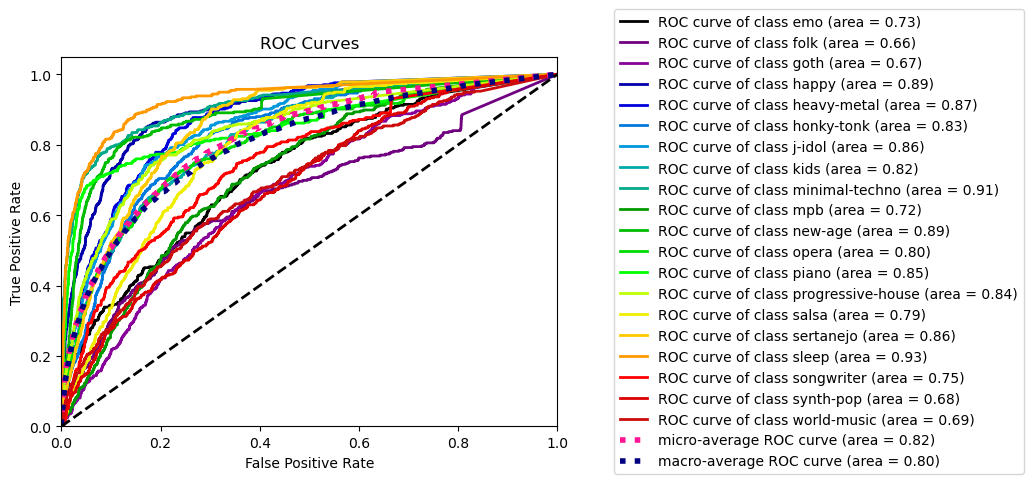

TOP 5 F1-SCORE:
sleep: 0.5855161787365177
minimal-techno: 0.5411764705882353
piano: 0.5038167938931297
new-age: 0.46588235294117647
happy: 0.4346764346764347


FLOP 5 F1-SCORE:
mpb: 0.05333333333333334
goth: 0.06980802792321117
synth-pop: 0.09001956947162426
folk: 0.10934744268077601
emo: 0.13725490196078433


In [7]:
# KNN selected model 
model = KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=60,
                     weights='distance')
y_pred = decode_y(cross_val_predict(model, X_train_dist_pca, y_train, cv=10), enc_dict)
y_pred_proba = cross_val_predict(model, X_train_dist_pca, y_train, cv=10, method='predict_proba')

print(classification_report(decode_y(y_train, enc_dict), y_pred))
plot_roc(decode_y(y_train, enc_dict), y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(decode_y(y_train, enc_dict), y_pred)

In [24]:
# decision tree
parameters = {'criterion': ['entropy'],
              'min_samples_split': [32,64,128,200,300,400,500,600,700],
              'min_samples_leaf': [10,14,18,24,30,40,50,60,75,100],
              }
dtc = DecisionTreeClassifier(random_state=8)
clf = GridSearchCV(
    dtc, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    verbose=2
    )
clf.fit(X_train_dist_pca, y_train)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
DecisionTreeClassifier(criterion='entropy', min_samples_leaf=18,
                       min_samples_split=32, random_state=8)
{'criterion': 'entropy', 'min_samples_leaf': 18, 'min_samples_split': 32}
0.2524


                   precision    recall  f1-score   support

              emo       0.16      0.14      0.15       375
             folk       0.13      0.15      0.14       375
             goth       0.08      0.05      0.07       375
            happy       0.33      0.41      0.37       375
      heavy-metal       0.24      0.32      0.28       375
       honky-tonk       0.19      0.25      0.21       375
           j-idol       0.26      0.27      0.27       375
             kids       0.23      0.23      0.23       375
   minimal-techno       0.46      0.50      0.48       375
              mpb       0.14      0.11      0.13       375
          new-age       0.40      0.44      0.42       375
            opera       0.22      0.25      0.23       375
            piano       0.56      0.43      0.48       375
progressive-house       0.26      0.28      0.27       375
            salsa       0.15      0.17      0.16       375
        sertanejo       0.20      0.30      0.24       

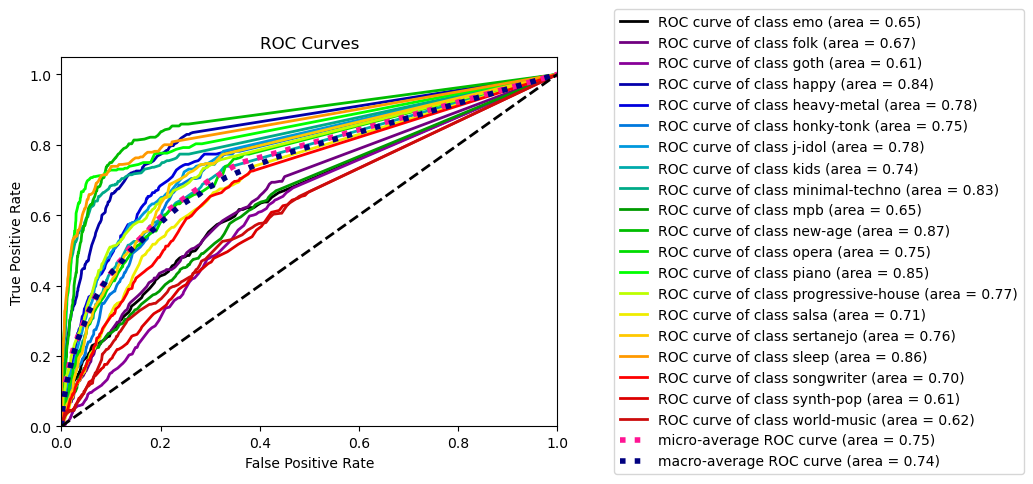

TOP 5 F1-SCORE:
sleep: 0.5151953690303908
piano: 0.48338368580060426
minimal-techno: 0.4793814432989691
new-age: 0.41878172588832485
happy: 0.3681710213776722


FLOP 5 F1-SCORE:
goth: 0.06514657980456026
synth-pop: 0.07216494845360824
world-music: 0.10048622366288493
mpb: 0.12797619047619047
folk: 0.136986301369863


In [9]:
# Decision Tree selected model 
model = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=18,
                       min_samples_split=32, random_state=8)
y_pred = decode_y(cross_val_predict(model, X_train_dist_pca, y_train, cv=5), enc_dict)
y_pred_proba = cross_val_predict(model, X_train_dist_pca, y_train, cv=5, method='predict_proba')

print(classification_report(decode_y(y_train, enc_dict), y_pred))
plot_roc(decode_y(y_train, enc_dict), y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(decode_y(y_train, enc_dict), y_pred)

### Test:

Decision Tree:

In [18]:
dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=18,
                       min_samples_split=32, random_state=8)
dt.fit(X_train_dist_pca, y_train)
y_pred = dt.predict(X_test_dist_pca)
print(classification_report(decode_y(y_test, enc_dict), decode_y(y_pred,enc_dict)))

                   precision    recall  f1-score   support

              emo       0.12      0.13      0.12       125
             folk       0.11      0.11      0.11       125
             goth       0.08      0.08      0.08       125
            happy       0.38      0.46      0.41       125
      heavy-metal       0.21      0.25      0.23       125
       honky-tonk       0.21      0.31      0.25       125
           j-idol       0.23      0.24      0.23       125
             kids       0.24      0.26      0.25       125
   minimal-techno       0.44      0.50      0.46       125
              mpb       0.13      0.09      0.10       125
          new-age       0.42      0.38      0.40       125
            opera       0.25      0.24      0.25       125
            piano       0.50      0.50      0.50       125
progressive-house       0.25      0.26      0.26       125
            salsa       0.10      0.14      0.11       125
        sertanejo       0.19      0.18      0.18       

KNN:

In [20]:
knn = KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=60,
                     weights='distance')
knn.fit(X_train_dist_pca, y_train)
y_pred = knn.predict(X_test_dist_pca)
print(classification_report(decode_y(y_test, enc_dict), decode_y(y_pred,enc_dict)))

                   precision    recall  f1-score   support

              emo       0.23      0.10      0.13       125
             folk       0.10      0.06      0.07       125
             goth       0.05      0.02      0.03       125
            happy       0.43      0.54      0.48       125
      heavy-metal       0.25      0.44      0.32       125
       honky-tonk       0.22      0.35      0.27       125
           j-idol       0.26      0.32      0.29       125
             kids       0.24      0.16      0.19       125
   minimal-techno       0.74      0.44      0.55       125
              mpb       0.15      0.06      0.08       125
          new-age       0.43      0.53      0.47       125
            opera       0.34      0.37      0.35       125
            piano       0.57      0.43      0.49       125
progressive-house       0.41      0.36      0.38       125
            salsa       0.17      0.27      0.21       125
        sertanejo       0.22      0.56      0.32       